# Clasificación utilizando Árbol de decisión

### 1. Importamos las librerias necesarias

In [32]:
# Tratamiento de datos
import numpy as np
import pandas as pd
#import statsmodels.api as sm

# Gráficos
import matplotlib.pyplot as plt

# Preprocesado y modelado
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

# Configuración warnings
import warnings
warnings.filterwarnings('once')

### 2. Cargamos el dataset de vinos

In [2]:
datos = pd.read_csv('winequality-red.csv')
datos = pd.DataFrame(datos)
datos

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### 3. Dividimos el dataset en datos de entrenamiento y de prueba

In [3]:
# División de los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "quality"),
                                        datos['quality'],
                                        random_state = 123
                                    )

### 4. Creamos el modelo de arbol clasificador

In [4]:
# Creación del modelo
modelo = DecisionTreeClassifier(
            max_depth         = 4,
            criterion         = 'gini',
            random_state      = 123
          )

### 5. Entrenamos el modelo

In [5]:
# Entrenamiento del modelo
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=123)

### 6. Graficamos el árbol

Profundidad del árbol: 4
Número de nodos terminales: 15


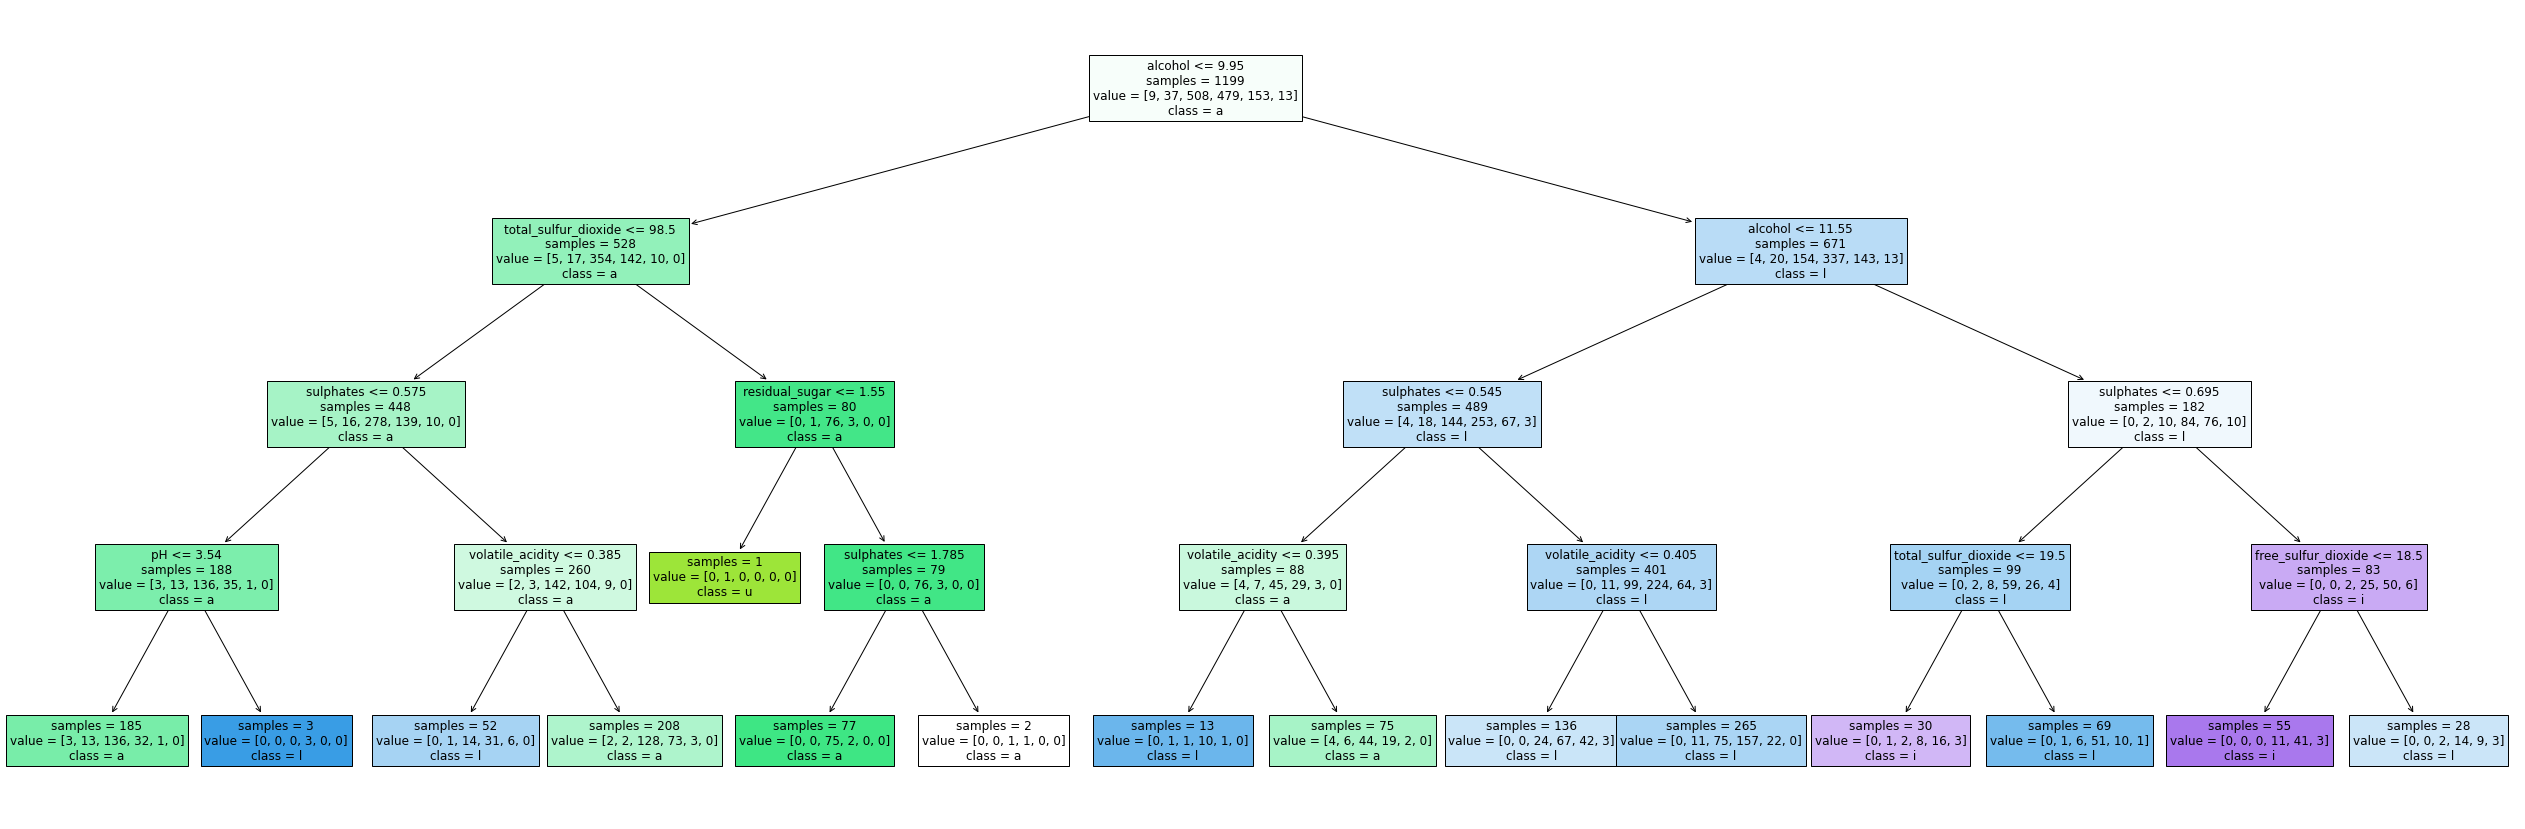

In [6]:
# Estructura del árbol creado
fig, ax = plt.subplots(figsize=(45, 15))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,           
            feature_names = datos.drop(columns = "quality").columns,
            class_names   = 'quality',
            filled        = True,
            impurity      = False,
            fontsize      = 12,
            ax            = ax
       )

### 7. Realizamos prediccions sobre el cojunto de prueba y mostramos metricas

In [39]:
# Predecir la respuesta para el conjunto de datos de prueba
y_pred = modelo.predict(X_test)

# Exactitud del modelo: ¿con qué frecuencia es correcto el clasificador?
print("Exactitud:",metrics.accuracy_score(y_test, y_pred))

# Precisión del modelo: ¿qué porcentaje de tuplas positivas se etiquetan como tales?
print("Presición:",metrics.precision_score(y_test, y_pred, average=None))

# Recordatorio de modelos: ¿qué porcentaje de tuplas positivas se etiquetan como tales?
print("Recuperacion:",metrics.recall_score(y_test, y_pred))

# La puntuación F1 se puede interpretar como un promedio ponderado de la precisión
#y la recuperación, donde una puntuación F1 alcanza su mejor valor en 1 y la peor puntuación en 0. 
print("F equilibrada:",metrics.f1_score(y_test, y_pred))

print("Pérdida de registros:",metrics.log_loss(y_test, y_pred))

print("Área bajo la curva de la curva:",metrics.roc_auc_score(y_test, y_pred))

Exactitud: 0.5225
Presición: [0.         0.         0.62576687 0.45771144 0.41666667 0.        ]


/home/lucila/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

###  8. Podamos el arbol y reentrenamos el modelo

In [13]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(3, 8, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 9,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train, y_train)

GridSearchCV(cv=9, estimator=DecisionTreeClassifier(random_state=123),
             param_grid={'ccp_alpha': array([3.        , 3.55555556, 4.11111111, 4.66666667, 5.22222222,
       5.77777778, 6.33333333, 6.88888889, 7.44444444, 8.        ])},
             return_train_score=True, scoring='accuracy')

In [14]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 3.0}

### 9. Graficamos el arbol del modelo final

Profundidad del árbol: 0
Número de nodos terminales: 1


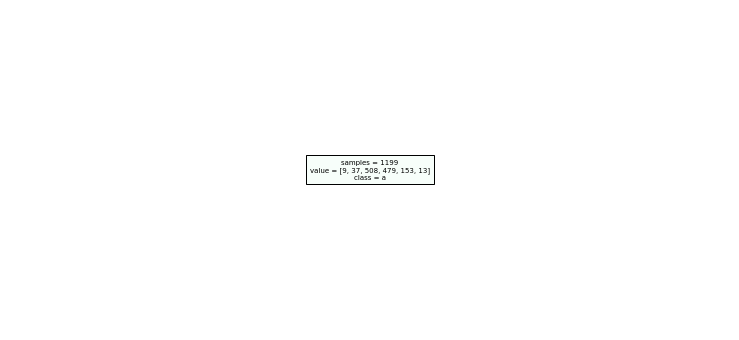

In [17]:
# Estructura del árbol creado
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo_final,           
            feature_names = datos.drop(columns = "quality").columns,
            class_names   = 'quality',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

In [18]:
predicciones = modelo_final.predict(X_test)
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 43.25 %


### 10. Realizamos predicciones

In [19]:
ndf = X_test.head(1)
ndf

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
912,10.0,0.46,0.44,2.9,0.065,4.0,8.0,0.99674,3.33,0.62,12.2


In [20]:
una_pred = modelo_final.predict(X = ndf)
una_pred

array([5])

In [21]:
una_pred = modelo.predict(X = ndf)
una_pred

array([7])

In [22]:
datos.iloc[912]

fixed_acidity           10.00000
volatile_acidity         0.46000
citric_acid              0.44000
residual_sugar           2.90000
chlorides                0.06500
free_sulfur_dioxide      4.00000
total_sulfur_dioxide     8.00000
density                  0.99674
pH                       3.33000
sulphates                0.62000
alcohol                 12.20000
quality                  6.00000
Name: 912, dtype: float64

In [23]:
ndf = X_test.head(14)
ndf

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
912,10.0,0.460,0.44,2.9,0.065,4.0,8.0,0.99674,3.33,0.62,12.2
772,9.5,0.570,0.27,2.3,0.082,23.0,144.0,0.99782,3.27,0.55,9.4
1037,7.3,0.910,0.10,1.8,0.074,20.0,56.0,0.99672,3.35,0.56,9.2
1106,8.2,0.230,0.42,1.9,0.069,9.0,17.0,0.99376,3.21,0.54,12.3
263,7.9,0.370,0.23,1.8,0.077,23.0,49.0,0.99630,3.28,0.67,9.3
1029,7.7,0.580,0.01,1.8,0.088,12.0,18.0,0.99568,3.32,0.56,10.5
935,8.8,0.300,0.38,2.3,0.060,19.0,72.0,0.99543,3.39,0.72,11.8
1280,7.1,0.460,0.20,1.9,0.077,28.0,54.0,0.99560,3.37,0.64,10.4
31,6.9,0.685,0.00,2.5,0.105,22.0,37.0,0.99660,3.46,0.57,10.6
512,10.7,0.400,0.48,2.1,0.125,15.0,49.0,0.99800,3.03,0.81,9.7


In [24]:
una_pred = modelo_final.predict(X = ndf)
una_pred

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [25]:
una_pred = modelo.predict(X = ndf)
una_pred

array([7, 5, 5, 7, 6, 6, 6, 6, 6, 5, 5, 7, 5, 6])

In [29]:
datos.iloc[[912,772,1037,1106]]


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
912,10.0,0.46,0.44,2.9,0.065,4.0,8.0,0.99674,3.33,0.62,12.2,6
772,9.5,0.57,0.27,2.3,0.082,23.0,144.0,0.99782,3.27,0.55,9.4,5
1037,7.3,0.91,0.10,1.8,0.074,20.0,56.0,0.99672,3.35,0.56,9.2,5
1106,8.2,0.23,0.42,1.9,0.069,9.0,17.0,0.99376,3.21,0.54,12.3,6


In [30]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "quality").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo


,predictor,importancia
10,alcohol,0.561093
9,sulphates,0.159232
1,volatile_acidity,0.110959
6,total_sulfur_dioxide,0.110886
5,free_sulfur_dioxide,0.027884
8,pH,0.019647
3,residual_sugar,0.010299
0,fixed_acidity,0.000000
2,citric_acid,0.000000
4,chlorides,0.000000
